<img src="./images/header.png">

***

# Busca por sinais de explosões

In [1]:
# Author: Jake VanderPlas (adapted to PyMC3 by Brigitta Sipocz)
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt

import pymc3 as pm

from astroML.plotting.mcmc import plot_mcmc
from astroML.utils.decorators import pickle_results

[11.90370008 11.48214541 12.25492606 11.65562354 11.48825219 13.05830074
 11.17877957  9.91950609  8.97769899 11.05445173  9.867234   14.96769636
 12.74023142 11.04753594 10.3563664  10.70657317 10.01050002 11.96551766
 10.43661878 10.52559198 11.92487191  8.90327975  8.729515   11.27184231
  8.82687659 13.17758019  9.58638102  9.31113167 15.94162687 11.48051479
 11.86755896 11.2281428   9.13877431 14.43218144  9.73199663 12.34446051
 12.57709007 11.39784921 10.67320783 11.73379254 10.37642553  8.90059921
 10.99113509 11.3263859  10.24886579 10.75797521  9.56484645 11.84926373
 10.67229476 10.40746184 11.70812958 10.53924919  9.36351067 10.03183056
  9.36415392 10.67643329 11.65809697  9.79170124 10.39600671  8.90693849
  8.50874241 10.4393917  11.21389662 10.63503144 12.38314477 10.94447949
  9.2889745  11.11701629  8.85442368  9.5384154   9.97439011 11.71334272
  9.2977485  10.92595522 10.3584899   9.33652171 11.12663592  8.92006849
  8.85253135  9.56217996  9.50196755 11.92953205 10

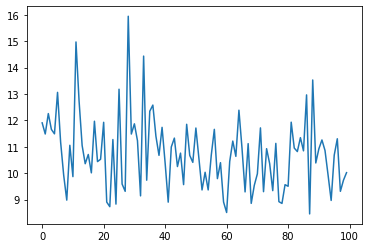

In [8]:
# ----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
# if "setup_text_plots" not in globals():
#     from astroML.plotting import setup_text_plots
# setup_text_plots(fontsize=8, usetex=True)
# ----------------------------------------------------------------------
# Set up toy dataset
def burst(t, b0, A, alpha, T):
    """Burst model"""
    mask = (t >= T)
    
    y = b0 + mask * A * np.exp(-alpha * (t - T))
    return y

np.random.seed(0)
N = 100
b0_true = 10
A_true = 5
alpha_true = 0.1
T_true = 50
sigma = 1.0

t = 100 * np.random.random(N)

y_true = burst(t, b0_true, A_true, alpha_true, T_true)
y_obs = np.random.normal(y_true, sigma)

print(y_obs)
plt.plot(y_obs)

In [ ]:
# ----------------------------------------------------------------------
# Set up and run the MCMC sampling
# We need to wrap it in a function in order to be able to pickle the result
#@pickle_results('matchedfilt_burst.pkl')
def compute_MCMC_results(draws=3000, tune=1000):
    with pm.Model():
        b0 = pm.Uniform('b0', 0, 50)
        A = pm.Uniform('A', 0, 50)
        T = pm.Uniform('T', 0, 100)
        log_alpha = pm.Uniform('log_alpha', -10, 10)

        y = pm.Normal('y', mu=burst(t, b0, A, np.exp(log_alpha), T),
                      sd=sigma, observed=y_obs)

        traces = pm.sample(draws=draws, tune=tune)
        
        return traces


traces = compute_MCMC_results()
print(traces)
mean_vals = pm.summary(traces)['mean']
mean_vals['alpha'] = np.exp(mean_vals.pop('log_alpha'))

labels = ['$b_0$', '$A$', '$T$', r'$\alpha$']

limits = [(9.2, 11.2), (2, 12), (45, 55), (0.0, 0.25)]
true = [b0_true, A_true, T_true, alpha_true]

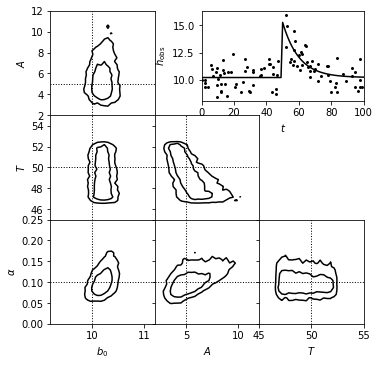

[10, 5, 50, 0.1]


In [9]:
# ------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(bottom=0.1, top=0.95,
                    left=0.1, right=0.95,
                    hspace=0.05, wspace=0.05)

# This function plots multiple panels with the traces
plot_mcmc([traces[i] for i in ['b0', 'A', 'T']] + [np.exp(traces['log_alpha'])],
          labels=labels, limits=limits,
          true_values=true, fig=fig, bins=30, colors='k')

# Plot the model fit
ax = fig.add_axes([0.5, 0.7, 0.45, 0.25])
t_fit = np.linspace(0, 100, 101)
y_fit = burst(t_fit, **mean_vals)

ax.scatter(t, y_obs, s=9, lw=0, c='k')
ax.plot(t_fit, y_fit, '-k')
ax.set_xlim(0, 100)
ax.set_xlabel('$t$')
ax.set_ylabel(r'$h_{\rm obs}$')

plt.show()
print(true)